# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import matplotlib.pyplot as plt

from datetime import datetime

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, min, max, split, udf, isnan, when, count, floor

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Normalizer, StandardScaler,  VectorAssembler, Bucketizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

23/02/16 00:19:07 WARN Utils: Your hostname, ivana-ThinkPad-E15-Gen-2 resolves to a loopback address: 127.0.1.1; using 192.168.178.35 instead (on interface wlp0s20f3)
23/02/16 00:19:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/16 00:19:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## 1.1 Load Data 

In [3]:
# Read the data
data_path = "mini_sparkify_event_data.json"
sparkify_df = spark.read.json(data_path)

## 1. 2. First look at the data

In [4]:
# Print the schema 
sparkify_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Convert the data to pandas frame, to get a better overview
sparkify_df.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286495,None,Logged Out,None,None,41,None,NaN,paid,None,GET,Home,NaN,500,None,200,1543622240000,None,
286496,None,Logged Out,None,None,42,None,NaN,paid,None,PUT,Login,NaN,500,None,307,1543622241000,None,
286497,None,Logged In,Emilia,F,43,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1.538337e+12,500,None,200,1543622248000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
286498,None,Logged In,Emilia,F,44,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,About,1.538337e+12,500,None,200,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011


From this overview we can see that the total number of rows in our data is 286500. 

## 1.3 Clean Data

### 1.3.1 Check for duplicates and drop if nesessery 

First let see if we have some duplicated data. If we have duplicates, these should be removed to avoid interfering with later observations. 

In [6]:
if sparkify_df.count() > sparkify_df.dropDuplicates().count():
    raise ValueError('Data has duplicates')

Since we don't have any duplicates, we have nothing to drop here.

### 1.3.2 Check for NaN values and drop them if it makes sence

In [7]:
sparkify_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sparkify_df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


Loking at the table with the overview of the nan values it seams like we have 2 patterns here:  
1. Relations between the NaN values in the columns: firstName, gender, lastName, location, registration, userAgent
2. Relations between the NaN values in the columns: artist, length, song

So let see if this is true:

In [8]:
# get the rows where firstName is true
sparkify_df.where(col("firstName").isNull()).toPandas()


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,NaN,free,None,GET,Help,NaN,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,NaN,free,None,PUT,Login,NaN,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,NaN,free,None,GET,Home,NaN,240,None,200,1538356678000,None,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8341,None,Logged Out,None,None,5,None,NaN,paid,None,GET,Home,NaN,498,None,200,1543604776000,None,
8342,None,Logged Out,None,None,6,None,NaN,paid,None,PUT,Login,NaN,498,None,307,1543604777000,None,
8343,None,Logged Out,None,None,40,None,NaN,paid,None,GET,Home,NaN,500,None,200,1543622135000,None,
8344,None,Logged Out,None,None,41,None,NaN,paid,None,GET,Home,NaN,500,None,200,1543622240000,None,


The previos table is showing us that the NaN values in the columns firstName, gender, lastName, location, registration, userAgent are really related. From the table we also can see that the NaN values are caused by user, which are logged out. In this case the user Id is an empty string. Since we don't have any information about the user, when they are logged out, we can drop the columns, where the user id is an empty string.

In [9]:
# drop the rows where the userId is empty
sparkify_df = sparkify_df.filter(sparkify_df["userId"] != "")
sparkify_df.count()

278154

After dropping the rows with the empty userId we have 278154 rows of data left. 

Let see if we can find something similar for the second pattern:

In [10]:
# get the rows where is true
sparkify_df.where(col("artist").isNull()).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,None,Logged In,Micah,M,84,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1538331630000,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1538331630000,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
3,None,Logged In,Alexi,F,4,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1532482662000,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
4,None,Logged In,Alexi,F,7,Warren,NaN,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1532482662000,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50041,None,Logged In,Emilia,F,28,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1538336771000,500,None,200,1543619556000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
50042,None,Logged In,Emilia,F,36,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1538336771000,500,None,200,1543621485000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
50043,None,Logged In,Emilia,F,39,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,Logout,1538336771000,500,None,307,1543622122000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
50044,None,Logged In,Emilia,F,43,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1538336771000,500,None,200,1543622248000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011


What we can see here is that this columns are none because the user is doing some other action than NextSong, since the user is not choosing any song, the columns artist, length und song have NaN values. Those rows are giving us some other important information about the user interaction with Sparkify, that is why we are not going to drop them.

### 1.3.3 Drop unnecessary columns

The data in the columns method, status does not provide any important information about the user behavior, so it would make sense to drop these two columns. 
For a better overview of the data set we are also going to drop the column userAgent because we don't intend to use this column for our analyses and feature engineering.
Since we have a unique userId, we can also drop the columns firstName and lastName, those contain sensitive information about the users and are not needed for the further analyses.

In [11]:
sparkify_df = sparkify_df.drop('method', 'status', 'userAgent', 'firstName', 'lastName')
sparkify_df.toPandas()

,artist,auth,gender,itemInSession,length,level,location,page,registration,sessionId,song,ts,userId
0,Martha Tilston,Logged In,M,50,277.89016,paid,"Bakersfield, CA",NextSong,1538173362000,29,Rockpools,1538352117000,30
1,Five Iron Frenzy,Logged In,M,79,236.09424,free,"Boston-Cambridge-Newton, MA-NH",NextSong,1538331630000,8,Canada,1538352180000,9
2,Adam Lambert,Logged In,M,51,282.82730,paid,"Bakersfield, CA",NextSong,1538173362000,29,Time For Miracles,1538352394000,30
3,Enigma,Logged In,M,80,262.71302,free,"Boston-Cambridge-Newton, MA-NH",NextSong,1538331630000,8,Knocking On Forbidden Doors,1538352416000,9
4,Daft Punk,Logged In,M,52,223.60771,paid,"Bakersfield, CA",NextSong,1538173362000,29,Harder Better Faster Stronger,1538352676000,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278149,Iron Maiden,Logged In,F,38,258.66404,paid,"New York-Newark-Jersey City, NY-NJ-PA",NextSong,1538336771000,500,Murders In The Rue Morgue (1998 Digital Remaster),1543622121000,300011
278150,None,Logged In,F,39,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",Logout,1538336771000,500,None,1543622122000,300011
278151,None,Logged In,F,43,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",Home,1538336771000,500,None,1543622248000,300011
278152,None,Logged In,F,44,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",About,1538336771000,500,None,1543622398000,300011


## 2.1 Define Churn

In [12]:
# define churn event
define_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0)
sparkify_df = sparkify_df.withColumn('is_churned', define_churn('page'))


In [13]:
# flag churned users
window_by_user_id = Window.partitionBy('userId')
sparkify_df = sparkify_df.withColumn('churn', max('is_churned').over(window_by_user_id))

## 2.2 Explore Data

### 2.1 Group by UserID for Analysis

In [14]:
# group by user id
grouped_by_userid_df = sparkify_df.groupBy('userId').agg(
    max('ts').alias('last_session_timestamp'), \
    max('gender').alias('gender'), \
    max('level').alias('level'), \
    min('registration').alias('registration_timestamp'), \
    max('churn').alias('churn') \
)

grouped_by_userid_df = grouped_by_userid_df.withColumn('lifetime_days', ((grouped_by_userid_df['last_session_timestamp'] - grouped_by_userid_df['registration_timestamp']) / 1000 / 60 / 60 / 24))
grouped_by_userid_df.toPandas().head()

,userId,last_session_timestamp,gender,level,registration_timestamp,churn,lifetime_days
0,10,1542631788000,M,paid,1538159495000,0,51.762650
1,100,1543587349000,M,paid,1537982255000,0,64.873773
2,100001,1538498205000,F,free,1534627466000,1,44.800220
3,100002,1543799476000,F,paid,1529934689000,0,160.472072
4,100003,1539274781000,F,free,1537309344000,1,22.748113


### 2.2 Analysis

#### 2.2.1 Check which actions user can do 

In [15]:
sparkify_df.select("page").dropDuplicates().sort("page").toPandas()

,page
0,About
1,Add Friend
2,Add to Playlist
3,Cancel
4,Cancellation Confirmation
5,Downgrade
6,Error
7,Help
8,Home
9,Logout


#### 2.2.2 Churned vs. Unchurned User

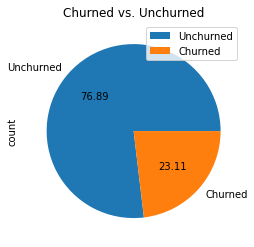

In [16]:
grouped_by_churn_df = grouped_by_userid_df.groupBy(['churn']).count()

grouped_by_churn_df.toPandas()\
    .plot(kind="pie",y='count', labels=['Unchurned', 'Churned'], autopct='%.2f')

plt.title('Churned vs. Unchurned')
plt.show()

#### 2.2.3 Churn by Gender

We can observe that the churn by gender 'male' is a bit higher than with 'female'.

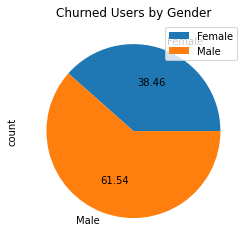

In [17]:
churn_by_gender_df = grouped_by_userid_df.groupBy(['gender', 'churn']).count()
churn_by_gender_df_churned = churn_by_gender_df.select(['gender', 'count']).filter(col('churn') == 1).orderBy('gender')

churn_by_gender_df_churned.toPandas().plot(kind="pie", labels=['Female', 'Male'], y='count', autopct='%.2f')
plt.title('Churned Users by Gender')
plt.show()

But the same plot for the existing users (not churned) shows an almost equal distribution between 'male' and 'female'

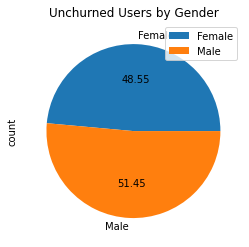

In [18]:
churn_by_gender_df_exist = churn_by_gender_df.select(['gender', 'count']).filter(col('churn') == 0).orderBy('gender')

churn_by_gender_df_exist.toPandas().plot(kind="pie", labels=['Female', 'Male'], y='count', autopct='%.2f')
plt.title('Unchurned Users by Gender')
plt.show()

#### 2.2.4 Churn by lifetime

When we analyze churn by lifetime, the highest churn occurs between 30 and 90 days.

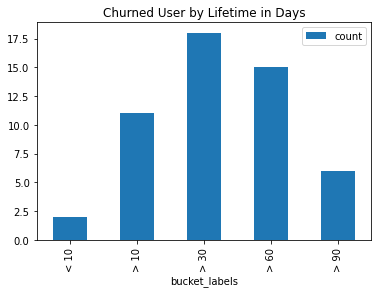

In [19]:
splits = [-float("inf"),10, 30, 60, 90, float("inf")]
result_bucketizer = Bucketizer(splits=splits, inputCol="lifetime_days",outputCol="lifetime_bucket").transform(grouped_by_userid_df)

def labels(x):
    if int(x) == 0:
        return "< 10"
    if int(x) == len(splits) - 1:
        return "> 90"
    else:
        return "> " + str(splits[int(x)])

bucket_labels = udf(labels)

bucket_df = result_bucketizer.withColumn('bucket_labels', bucket_labels('lifetime_bucket'))
group_by_bucket_labels = bucket_df.groupBy('bucket_labels','churn').count().select(['bucket_labels', 'count']).filter(col('churn') == 1).orderBy('bucket_labels')

plot_df = group_by_bucket_labels.toPandas()

plot_df.plot(kind="bar",x='bucket_labels', y='count')
plt.title('Churned User by Lifetime in Days')
plt.show()

#### 2.2.5  Free vs. Paid

Churn with paid users is much higher than with unpaid accounts.

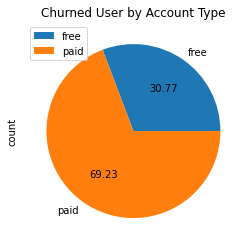

In [20]:
churn_by_level_df = grouped_by_userid_df.groupBy(['level', 'churn']).count()
churn_by_level_df_churned = churn_by_level_df.select(['level', 'count']).filter(col('churn') == 1).orderBy('level')

churn_by_level_df_churned.toPandas().plot(kind="pie",labels=['free', 'paid'], y='count', autopct='%.2f')
plt.title('Churned User by Account Type')
plt.show()

# 3. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## 3.1 Define Features

### 3.1.1 gender

In [22]:
gender = sparkify_df.select("userId", "gender").dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender')
gender.toPandas()

,userId,gender
0,44,0
1,46,0
2,41,0
3,72,0
4,300023,0
...,...,...
220,27,1
221,124,0
222,54,0
223,151,1


### 3.1.2 last_account_type

In [23]:
window_by_user_id = Window.partitionBy('userId')
sparkify_df = sparkify_df.withColumn('last_ts', max('ts').over(window_by_user_id))

last_account_type = sparkify_df.select('userId', col('level').alias('last_account_type')).where(sparkify_df.ts == sparkify_df.last_ts).dropDuplicates().replace(['free', 'paid'], ['0', '1'], 'last_account_type')
last_account_type.toPandas()

,userId,last_account_type
0,10,1
1,100,1
2,100001,0
3,100002,1
4,100003,0
...,...,...
220,95,0
221,96,1
222,97,1
223,98,1


### 3.1.3 lifetime_days

In [24]:
sparkify_df = sparkify_df.withColumn('lifetime_days', (sparkify_df.last_ts - sparkify_df.registration) / 1000 / 60 / 60 / 24)
lifetime_days = sparkify_df.select('userId', 'lifetime_days').dropDuplicates()
lifetime_days.toPandas()

,userId,lifetime_days
0,10,51.762650
1,100,64.873773
2,100001,44.800220
3,100002,160.472072
4,100003,22.748113
...,...,...
220,95,62.266343
221,96,73.936690
222,97,87.393426
223,98,63.409618


### 3.1.4 num_sessions

In [25]:
num_sessions = sparkify_df.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions')
num_sessions.toPandas()

,userId,num_sessions
0,100010,7
1,200002,6
2,125,1
3,51,10
4,124,29
...,...,...
220,45,16
221,57,2
222,200021,17
223,119,6


### 3.1.5 num_songs

In [26]:
num_songs = sparkify_df.select('userId', 'song').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_songs')
num_songs.toPandas()

,userId,num_songs
0,100010,270
1,200002,379
2,125,9
3,51,1855
4,124,3340
...,...,...
220,45,1351
221,57,91
222,200021,1125
223,119,172


### 3.1.6 num_friends_added

In [27]:
num_friends_added = sparkify_df.select('userId','page').where(sparkify_df['page'] == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'friends_added') 
num_friends_added.toPandas()

,userId,friends_added
0,100010,4
1,200002,4
2,51,28
3,124,74
4,7,1
...,...,...
201,50,9
202,45,22
203,200021,19
204,119,4


### 3.1.7 num_thumbs_up

In [28]:
num_thumbs_up = sparkify_df.select('userId','page').where(sparkify_df['page'] == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'thumbs_up') 
num_thumbs_up.toPandas()

,userId,thumbs_up
0,100010,17
1,200002,21
2,51,100
3,124,171
4,7,7
...,...,...
215,45,67
216,57,3
217,200021,55
218,119,7


### 3.1.8 num_thumbs_down

In [29]:
num_thumbs_down = sparkify_df.select('userId','page').where(sparkify_df['page'] == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'thumbs_down') 
num_thumbs_down.toPandas()

,userId,thumbs_down
0,100010,5
1,200002,6
2,51,21
3,124,41
4,7,1
...,...,...
198,45,13
199,57,2
200,200021,35
201,119,1


### 3.1.9 num_adds_playlist


In [30]:
num_adds_playlist= sparkify_df.select('userId','page').where(sparkify_df['page'] == 'Add to Playlist').groupBy('userId').count().withColumnRenamed('count', 'adds_playlist') 
num_adds_playlist.toPandas()

,userId,adds_playlist
0,100010,7
1,200002,8
2,51,52
3,124,118
4,7,5
...,...,...
210,145,27
211,45,43
212,200021,30
213,119,5


### 3.1.10 num_help_needed

In [31]:
num_help_needed = sparkify_df.select('userId','page').where(sparkify_df['page'] == 'Help').groupBy('userID').count().withColumnRenamed('count', 'help_needed') 
num_help_needed.toPandas()

,userID,help_needed
0,100010,2
1,200002,2
2,51,12
3,124,23
4,7,1
...,...,...
187,45,5
188,57,1
189,200021,4
190,119,3


## 3.2 Create ML Dataframe

### 3.2.1 Join feature tables together 

In [32]:
ml_df = gender.join(last_account_type, on = 'UserId', how = 'left')\
                     .join(lifetime_days, on = 'UserId', how = 'left')\
                     .join(num_sessions, on = 'UserId', how = 'left')\
                     .join(num_songs, on = 'UserId', how = 'left')\
                     .join(num_friends_added, on = 'UserId', how = 'left')\
                     .join(num_thumbs_up, on = 'UserId', how = 'left')\
                     .join(num_thumbs_down, on = 'UserId', how = 'left')\
                     .join(num_adds_playlist, on = 'UserId', how = 'left')\
                     .join(num_help_needed, on = 'UserId', how = 'left')
                        
                     
ml_df.orderBy("UserId").toPandas().head()

,userId,gender,last_account_type,lifetime_days,num_sessions,num_songs,friends_added,thumbs_up,thumbs_down,adds_playlist,help_needed
0,10,1,1,51.762650,6,630,12.0,37.0,4.0,9.0,1.0
1,100,1,1,64.873773,35,2303,49.0,148.0,27.0,61.0,18.0
2,100001,0,0,44.800220,4,130,2.0,8.0,2.0,3.0,1.0
3,100002,0,1,160.472072,4,194,1.0,5.0,NaN,5.0,NaN
4,100003,0,0,22.748113,2,52,NaN,3.0,NaN,2.0,1.0


### 3.2.2 Fill NaN values with 0

We have NaN values, because the last 5 features (friends_added, thumbs_up, thumbs_down, adds_playlist, help_needed) were calculated on the page column, by selecting the userIds, where the wanted page is in the page column, we only have the userIds in the feature column for the user which interact with this page, all other user didn't interact with this page an should be set to 0.   

In [33]:
ml_df = ml_df.fillna(0)

### 3.2.3 Add curn column as label

In [34]:
label = sparkify_df.select('userId', col('churn').alias('label')).dropDuplicates()
ml_df = ml_df.join(label, on = 'userId', how = 'left')

### 3.2.3 Change types to numeric types

In [33]:
# check which values should be changed
ml_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- last_account_type: string (nullable = true)
 |-- lifetime_days: double (nullable = false)
 |-- num_sessions: long (nullable = true)
 |-- num_songs: long (nullable = true)
 |-- friends_added: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- adds_playlist: long (nullable = true)
 |-- help_needed: long (nullable = true)
 |-- label: string (nullable = true)



In [35]:
# change types to long
ml_df = ml_df.withColumn('userId', ml_df.userId.cast('long')) \
                           .withColumn('gender', ml_df.gender.cast('long')) \
                           .withColumn('last_account_type', ml_df.last_account_type.cast('long')) \
                           .withColumn('lifetime_days', ml_df.lifetime_days.cast('long'))\
                           .withColumn('label', ml_df.label.cast('long'))

##### Take an overview of the final table which will be used in the modeling part:

In [36]:
ml_df.orderBy('userId').toPandas()

,userId,gender,last_account_type,lifetime_days,num_sessions,num_songs,friends_added,thumbs_up,thumbs_down,adds_playlist,help_needed,label
0,2,0,1,69,7,714,20,29,6,13,4,0
1,3,1,1,80,4,212,1,14,3,4,1,1
2,4,1,1,62,22,1800,46,95,26,59,12,0
3,5,1,0,48,6,160,3,11,0,8,2,0
4,6,1,1,256,24,2679,41,165,31,83,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...
220,300021,0,1,69,58,3196,89,336,36,107,16,0
221,300022,1,1,102,11,354,11,25,5,9,3,0
222,300023,0,1,150,27,1604,31,169,16,63,10,0
223,300024,0,1,38,1,88,2,6,0,2,0,0


# 3. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## 3.1 Prepare data for training an evaluation

### 3.1.1 Create Vector Assembler

In [36]:
features = ['gender', 'last_account_type', 'lifetime_days', 'num_sessions', 'num_songs', 'friends_added', 'thumbs_up', 'thumbs_down', 'adds_playlist', 'help_needed']
assembler = VectorAssembler(inputCols= features, outputCol='features_vectors')
ml_df = assembler.transform(ml_df)

### 3.1.2  Scale Features

In [37]:
scaler = StandardScaler(inputCol='features_vectors', outputCol='features')
scaler_model = scaler.fit(ml_df)
ml_df= scaler_model.transform(ml_df)

### 3.1.3 Split data into train and test sets: 

In [38]:
data = ml_df.select('label', 'features')
train, test = data.randomSplit([0.8, 0.2], seed = 42)

## 3.2 Train and Evaluate Models

### 3.2.1 Create evaluation function

In [39]:
def evaluate_model(model, dataset):
    """
    Evaluates the model on the given dataset and prints the results.
    Metrics: accuracy and f1 score
    
    @param model: prerained model
    @param dataset: the dataset which need to be evaluated
    """
    # make predictions
    predictions = model.transform(dataset)
    
    # set evaluator
    evaluator = MulticlassClassificationEvaluator()
    
    # compute accuracy 
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: 'accuracy'})
    
    # compute f1-score
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})
    
    # print results
    print(f'Model: {model}')
    print(f'Accuracy: {accuracy}')
    print(f'F1-Score: {f1_score}')
    


### 3.2.2 Logistic Regression Classifier

#### train model

In [40]:
# initialize logistic regresion
lr =  LogisticRegression()

# train model 
start_time_lr = datetime.now()
lr_model = lr.fit(train)
end_time_lr = datetime.now()

# save model
lr_model.save('lr_model')

print(f'Model training duration: {end_time_lr - start_time_lr}')

Model training duration: 0:00:32.884421


#### evluate model on test set

In [41]:
evaluate_model(lr_model, test)

Model: LogisticRegressionModel: uid=LogisticRegression_94d1e0108504, numClasses=2, numFeatures=10
Accuracy: 0.7714285714285715
F1-Score: 0.7523809523809523


### 3.2.3 Gradient-Boosted Tree Classifier

#### train model

In [42]:
# initialize  gradient-boosted tree classifier
gbt = GBTClassifier()

# train model 
start_time_gbt = datetime.now()
gbt_model = gbt.fit(train)
end_time_gbt = datetime.now()

# save model
gbt_model.save('gbt_model')

print(f'Model training duration: {end_time_gbt - start_time_gbt}')

Model training duration: 0:00:21.442559


#### evluate model on test set

In [43]:
evaluate_model(gbt_model, test)

Model: GBTClassificationModel: uid = GBTClassifier_fb8d4d0bff33, numTrees=20, numClasses=2, numFeatures=10
Accuracy: 0.7428571428571429
F1-Score: 0.7615584415584415


### 3.2.4 Random Forest Classifier

#### train model

In [44]:
# initialize random forest classifier
rf = RandomForestClassifier()

# train model 
start_time_rf = datetime.now()
rf_model = rf.fit(train)
end_time_rf = datetime.now()

# save model
rf_model.save('rf_model')

print(f'Model training duration: {end_time_rf - start_time_rf}')

Model training duration: 0:00:44.234641


#### evluate model on test set

In [45]:
evaluate_model(rf_model, test)

Model: RandomForestClassificationModel: uid=RandomForestClassifier_03c95996e4a9, numTrees=20, numClasses=2, numFeatures=10
Accuracy: 0.7714285714285715
F1-Score: 0.7714285714285715


## 3.3 Improvement: Tune Models 

### 3.3.1 Logistic Regression Classifier

#### train model

In [47]:
# initialize logistic regresion
lr =  LogisticRegression()

# build parameter grid
param_grid_lr = ParamGridBuilder()\
                    .addGrid(lr.regParam,[0.0, 0.5])\
                    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
                    .addGrid(lr.maxIter, [20, 100])\
                    .build()

# set crossvalidator
cross_val_lr = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid_lr,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

# train model 
start_time_lr = datetime.now()
lr_model_tuned = cross_val_lr.fit(train)
end_time_lr = datetime.now()

# save_model
lr_model_tuned.save('lr_model_tuned')

print(f'Model training duration: {end_time_lr - start_time_lr}')

Model training duration: 0:19:41.675856


#### evluate model on test set

In [48]:
evaluate_model(lr_model_tuned, test)

Model: CrossValidatorModel_e893e32ada85
Accuracy: 0.7714285714285715
F1-Score: 0.7523809523809523


#### print parameter values for the best model

In [66]:
best_lr_model = lr_model_tuned.bestModel
print(f'Best parameters: {best_lr_model._java_obj.getRegParam()}, {best_lr_model._java_obj.getElasticNetParam()}, {best_lr_model._java_obj.getMaxIter()}')

Best parameters: 0.0, 0.0, 20  


### 3.3.2 Gradient-Boosted Tree Classifier

#### train model

In [73]:
# initialize gradient-boosted tree classifier
gbt = GBTClassifier()

# build parameter grid
param_grid_gbt = ParamGridBuilder()\
                    .addGrid(gbt.maxDepth, [5, 7])\
                    .addGrid(gbt.maxIter, [10, 20, 25])\
                    .build()


# set crossvalidator
cross_val_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=param_grid_gbt,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
# train model 
start_time_gbt = datetime.now()
gbt_model_tuned = cross_val_gbt.fit(train)
end_time_gbt = datetime.now()

# save model 
gbt_model_tuned.save('gbt_model_tuned')

print(f'Model training duration: {end_time_gbt - start_time_gbt}')

Model training duration: 0:52:57.463600


#### evluate model on test set

In [74]:
evaluate_model(gbt_model_tuned, test)

Model: CrossValidatorModel_0d94f463838c
Accuracy: 0.7428571428571429
F1-Score: 0.7615584415584415


#### print parameter values for the best model

In [75]:
best_gbt_model = gbt_model_tuned.bestModel
print(f'Best parameters: {best_gbt_model._java_obj.getMaxDepth()}, {best_gbt_model._java_obj.getMaxIter()}')

Best parameters: 5, 25


### 3.3.3 Random Forest Classifier

#### train model

In [78]:
# initialize random forest classifier
rf = RandomForestClassifier()

# build parameter grid
param_grid_rf = ParamGridBuilder()\
                    .addGrid(rf.numTrees, [10, 20, 30])\
                    .addGrid(rf.impurity,['gini', 'entropy'])\
                    .build()

# set crossvalidator
cross_val_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid_rf,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
# train model 
start_time_rf = datetime.now()
rf_model_tuned = cross_val_rf.fit(train)
end_time_rf = datetime.now()

# save model
rf_model_tuned.save('rf_model_tuned')

print(f'Model training duration: {end_time_rf - start_time_rf}')

Model training duration: 0:07:08.742566


#### evluate model on test set

In [79]:
evaluate_model(rf_model_tuned, test)

Model: CrossValidatorModel_ff80d4487774
Accuracy: 0.8
F1-Score: 0.7926040061633283


#### print parameter values for the best model

In [80]:
best_rf_model = rf_model_tuned.bestModel
print(f'Best parameters: {best_rf_model._java_obj.getNumTrees()}, {best_rf_model._java_obj.getImpurity()}')

Best parameters: 10, gini
